# Common Task: COCA Dataset Preprocessing
**PrediCT GSoC 2026 — Project 2: Radiomics Feature Extraction and Calcium Phenotype Discovery**

Shreyas Chitransh

In [1]:
import os
import glob
import json
import warnings
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import pydicom
import SimpleITK as sitk
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from scipy import ndimage

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [2]:
DATA_ROOT = Path("../coca_project")
RESAMPLED_DIR = DATA_ROOT / "data_resampled"
CANONICAL_DIR = DATA_ROOT / "data_canonical"
RAW_DIR = DATA_ROOT / "data_raw"
SCAN_INDEX_CSV = CANONICAL_DIR / "tables" / "scan_index.csv"

OUTPUT_DIR = Path("../results/common_task")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

CALCIUM_HU_MIN = 130
CALCIUM_HU_MAX = 1500
CARDIAC_HU_CENTER = 50
CARDIAC_HU_WIDTH = 350

AGATSTON_CATEGORIES = {
    0: "Zero (0)",
    1: "Mild (1-99)",
    2: "Moderate (100-399)",
    3: "Severe (≥400)"
}

## Data Discovery
Loading the scan index and checking which scans have valid NIfTI files on disk.

In [3]:
scan_df = pd.read_csv(SCAN_INDEX_CSV)
print(f"Scan index: {len(scan_df)} entries")

valid_scans = []
missing_scans = []

for _, row in scan_df.iterrows():
    scan_id = row['scan_id']
    img_path = RESAMPLED_DIR / scan_id / f"{scan_id}_img.nii.gz"
    seg_path = RESAMPLED_DIR / scan_id / f"{scan_id}_seg.nii.gz"

    if img_path.exists() and seg_path.exists():
        valid_scans.append({
            'patient_id': row['patient_id'],
            'scan_id': scan_id,
            'calcium_voxels': row['voxels'],
            'num_slices_with_calcium': row['num_slices'],
            'img_path': str(img_path),
            'seg_path': str(seg_path),
        })
    else:
        missing_scans.append(scan_id)

scan_registry = pd.DataFrame(valid_scans)
print(f"Valid scans: {len(valid_scans)}, Missing: {len(missing_scans)}")

Scan index: 787 entries
Valid scans: 787, Missing: 0


In [4]:
def load_scan_metadata(scan_id):
    meta_path = CANONICAL_DIR / "images" / scan_id / f"{scan_id}_meta.json"
    if meta_path.exists():
        with open(meta_path) as f:
            return json.load(f)
    return {}

slices_info = []
for scan_id in scan_registry['scan_id']:
    meta = load_scan_metadata(scan_id)
    slices_info.append({
        'scan_id': scan_id,
        'slices_with_calcium_indices': meta.get('slices_with_calcium', []),
    })

scan_registry = scan_registry.merge(pd.DataFrame(slices_info), on='scan_id', how='left')
print(f"Registry built: {len(scan_registry)} patients")
scan_registry.head()

Registry built: 787 patients


,patient_id,scan_id,calcium_voxels,num_slices_with_calcium,img_path,seg_path,slices_with_calcium_indices
0,135,2fff2f17d2e4,0,0,../coca_project/data_resampled/2fff2f17d2e4/2f...,../coca_project/data_resampled/2fff2f17d2e4/2f...,[]
1,307,73d01cdc4c19,12,1,../coca_project/data_resampled/73d01cdc4c19/73...,../coca_project/data_resampled/73d01cdc4c19/73...,[37]
2,763,9d761356fab4,0,0,../coca_project/data_resampled/9d761356fab4/9d...,../coca_project/data_resampled/9d761356fab4/9d...,[]
3,551,89b278e5e769,0,0,../coca_project/data_resampled/89b278e5e769/89...,../coca_project/data_resampled/89b278e5e769/89...,[]
4,61,3ce113c67995,12,1,../coca_project/data_resampled/3ce113c67995/3c...,../coca_project/data_resampled/3ce113c67995/3c...,[51]


## Dataset Statistics

In [5]:
n_total = len(scan_registry)
n_calcium = (scan_registry['calcium_voxels'] > 0).sum()
n_no_calcium = (scan_registry['calcium_voxels'] == 0).sum()

print(f"Total: {n_total}")
print(f"With calcium: {n_calcium} ({100*n_calcium/n_total:.1f}%)")
print(f"Without calcium: {n_no_calcium} ({100*n_no_calcium/n_total:.1f}%)")
print()
print(scan_registry['calcium_voxels'].describe())

Total: 787
With calcium: 447 (56.8%)
Without calcium: 340 (43.2%)

count      787.000000
mean       587.537484
std       1351.567198
min          0.000000
25%          0.000000
50%         33.000000
75%        464.500000
max      11678.000000
Name: calcium_voxels, dtype: float64


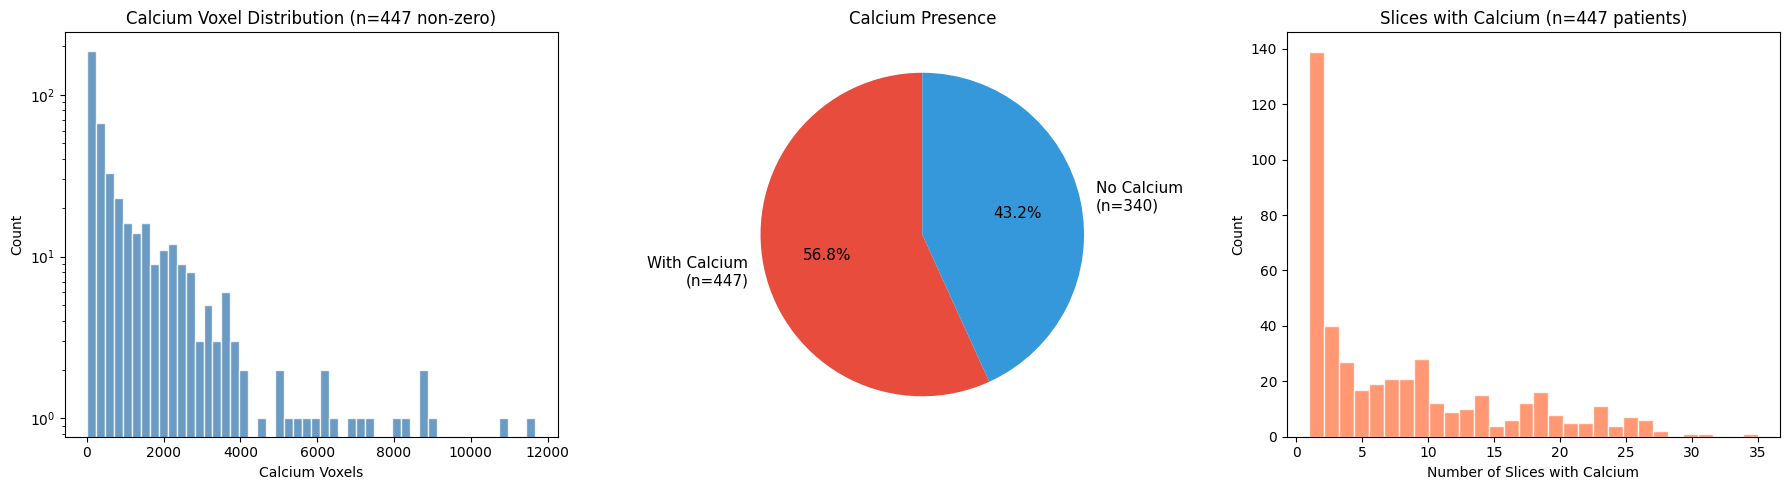

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

calcium_nonzero = scan_registry[scan_registry['calcium_voxels'] > 0]['calcium_voxels']
axes[0].hist(calcium_nonzero, bins=50, color='steelblue', edgecolor='white', alpha=0.8)
axes[0].set_xlabel('Calcium Voxels')
axes[0].set_ylabel('Count')
axes[0].set_title(f'Calcium Voxel Distribution (n={len(calcium_nonzero)} non-zero)')
axes[0].set_yscale('log')

axes[1].pie([n_calcium, n_no_calcium],
            labels=[f'With Calcium\n(n={n_calcium})', f'No Calcium\n(n={n_no_calcium})'],
            colors=['#e74c3c', '#3498db'],
            autopct='%1.1f%%', startangle=90, textprops={'fontsize': 11})
axes[1].set_title('Calcium Presence')

slices_nonzero = scan_registry[scan_registry['num_slices_with_calcium'] > 0]['num_slices_with_calcium']
axes[2].hist(slices_nonzero, bins=30, color='coral', edgecolor='white', alpha=0.8)
axes[2].set_xlabel('Number of Slices with Calcium')
axes[2].set_ylabel('Count')
axes[2].set_title(f'Slices with Calcium (n={len(slices_nonzero)} patients)')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'dataset_statistics.png', dpi=150, bbox_inches='tight')
plt.show()

## HU Windowing

Two windows — calcium (130–1500 HU) for isolating calcified tissue, and a
standard cardiac soft-tissue window (C=50, W=350) for anatomical context.
Windowing is done on-the-fly in the dataloader so raw HU stays intact for
Agatston computation and radiomics.

In [7]:
def apply_hu_window(image, center, width):
    lower = center - width / 2
    upper = center + width / 2
    windowed = np.clip(image, lower, upper)
    windowed = (windowed - lower) / (upper - lower)
    return windowed.astype(np.float32)

def apply_calcium_window(image):
    return apply_hu_window(image, center=(130 + 1500) / 2, width=1500 - 130)

def apply_cardiac_window(image):
    return apply_hu_window(image, center=CARDIAC_HU_CENTER, width=CARDIAC_HU_WIDTH)

Sample: fa0f815cff9c — 189 calcium voxels
Shape: (273, 273, 197), Spacing: (np.float32(0.7), np.float32(0.7), np.float32(0.7))
HU range: [-1023, 1349]


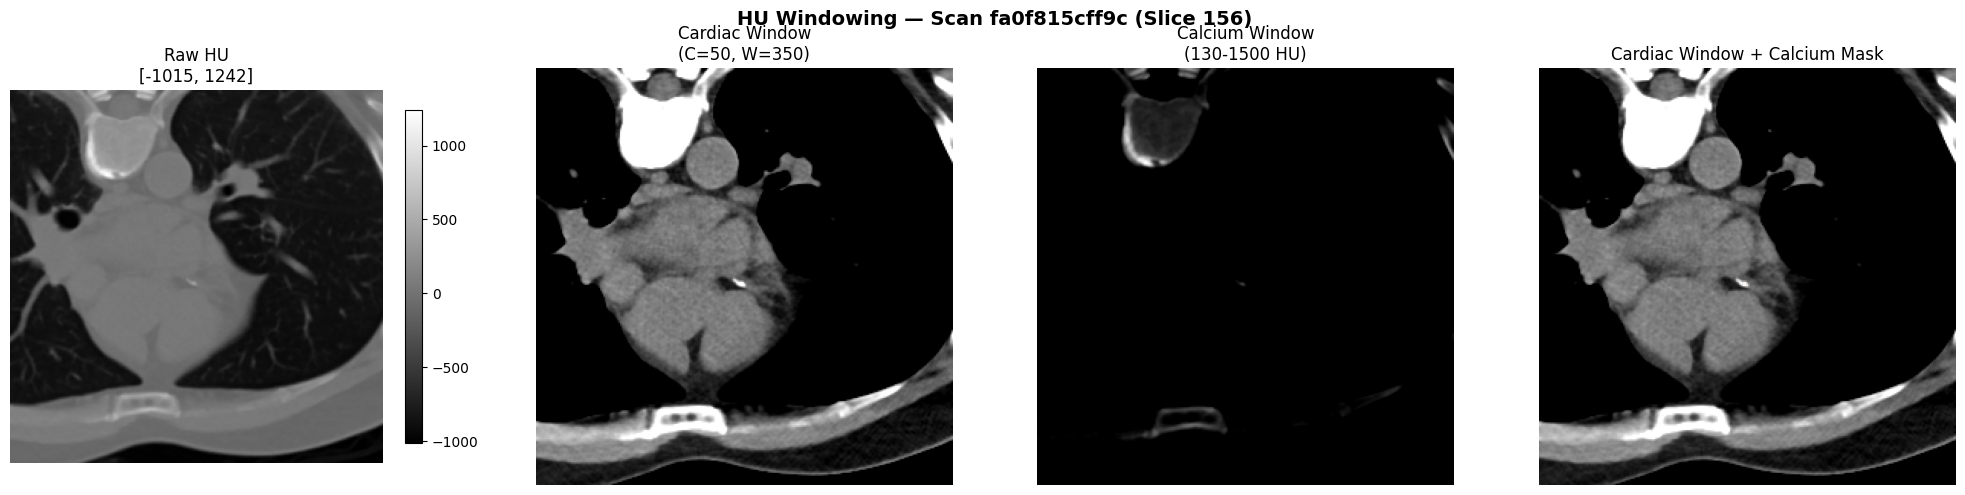

In [8]:
sample_calcium = scan_registry[scan_registry['calcium_voxels'] > 100].iloc[0]
print(f"Sample: {sample_calcium['scan_id']} — {sample_calcium['calcium_voxels']} calcium voxels")

img_nib = nib.load(sample_calcium['img_path'])
seg_nib = nib.load(sample_calcium['seg_path'])
img_data = img_nib.get_fdata()
seg_data = seg_nib.get_fdata()

print(f"Shape: {img_data.shape}, Spacing: {img_nib.header.get_zooms()}")
print(f"HU range: [{img_data.min():.0f}, {img_data.max():.0f}]")

calcium_slices = np.where(seg_data.sum(axis=(0, 1)) > 0)[0]
mid_calcium_slice = calcium_slices[len(calcium_slices) // 2] if len(calcium_slices) > 0 else img_data.shape[2] // 2

slice_img = img_data[:, :, mid_calcium_slice]
slice_seg = seg_data[:, :, mid_calcium_slice]

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

im0 = axes[0].imshow(slice_img.T, cmap='gray', origin='lower')
axes[0].set_title(f'Raw HU\n[{slice_img.min():.0f}, {slice_img.max():.0f}]')
plt.colorbar(im0, ax=axes[0], shrink=0.8)

axes[1].imshow(apply_cardiac_window(slice_img).T, cmap='gray', origin='lower')
axes[1].set_title('Cardiac Window\n(C=50, W=350)')

axes[2].imshow(apply_calcium_window(slice_img).T, cmap='gray', origin='lower')
axes[2].set_title('Calcium Window\n(130-1500 HU)')

axes[3].imshow(apply_cardiac_window(slice_img).T, cmap='gray', origin='lower')
if slice_seg.sum() > 0:
    mask_overlay = np.ma.masked_where(slice_seg.T == 0, slice_seg.T)
    axes[3].imshow(mask_overlay, cmap='Reds', alpha=0.6, origin='lower')
axes[3].set_title('Cardiac Window + Calcium Mask')

for ax in axes:
    ax.axis('off')

plt.suptitle(f'HU Windowing — Scan {sample_calcium["scan_id"]} (Slice {mid_calcium_slice})',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'hu_windowing_demo.png', dpi=150, bbox_inches='tight')
plt.show()

## Agatston Score Computation

Standard density-weighted area method. For each slice, connected calcium regions
(HU ≥ 130, area ≥ 1mm²) get a weight of 1–4 based on peak HU. The resampled
0.7mm data is used with a thickness correction factor since Agatston was designed
for 3mm slices.

In [9]:
def compute_agatston_score(img_data, seg_data, voxel_spacing):
    pixel_area_mm2 = voxel_spacing[0] * voxel_spacing[1]
    thickness_factor = voxel_spacing[2] / 3.0

    total_score = 0.0
    per_slice_scores = []
    total_lesions = 0

    for z in range(img_data.shape[2]):
        slice_img = img_data[:, :, z]
        slice_seg = seg_data[:, :, z]
        calcium_mask = (slice_seg > 0) & (slice_img >= 130)

        if not calcium_mask.any():
            per_slice_scores.append(0.0)
            continue

        labeled, n_lesions = ndimage.label(calcium_mask)
        total_lesions += n_lesions
        slice_score = 0.0

        for lesion_id in range(1, n_lesions + 1):
            lesion_mask = labeled == lesion_id
            lesion_area_mm2 = lesion_mask.sum() * pixel_area_mm2

            if lesion_area_mm2 < 1.0:
                continue

            max_hu = slice_img[lesion_mask].max()
            if max_hu >= 400:
                weight = 4
            elif max_hu >= 300:
                weight = 3
            elif max_hu >= 200:
                weight = 2
            elif max_hu >= 130:
                weight = 1
            else:
                weight = 0

            slice_score += lesion_area_mm2 * weight

        slice_score *= thickness_factor
        total_score += slice_score
        per_slice_scores.append(slice_score)

    return total_score, {'per_slice_scores': per_slice_scores, 'total_lesions': total_lesions}


def categorize_agatston(score):
    if score == 0:
        return 0
    elif score < 100:
        return 1
    elif score < 400:
        return 2
    else:
        return 3

In [10]:
print("Computing Agatston scores for all scans...")

agatston_records = []
for idx, row in scan_registry.iterrows():
    img_nib = nib.load(row['img_path'])
    seg_nib = nib.load(row['seg_path'])
    img_data = img_nib.get_fdata()
    seg_data = seg_nib.get_fdata()
    spacing = img_nib.header.get_zooms()

    score, info = compute_agatston_score(img_data, seg_data, spacing)
    category = categorize_agatston(score)

    agatston_records.append({
        'scan_id': row['scan_id'],
        'agatston_score': round(score, 2),
        'agatston_category': category,
        'agatston_label': AGATSTON_CATEGORIES[category],
        'total_lesions': info['total_lesions'],
    })

    if (idx + 1) % 100 == 0:
        print(f"  {idx + 1}/{len(scan_registry)}...")

agatston_df = pd.DataFrame(agatston_records)
scan_registry = scan_registry.merge(agatston_df, on='scan_id', how='left')

print(f"\nDone. Category distribution:")
print(scan_registry['agatston_label'].value_counts().sort_index())

Computing Agatston scores for all scans...
  100/787...
  200/787...
  300/787...
  400/787...
  500/787...
  600/787...
  700/787...

Done. Category distribution:
agatston_label
Mild (1-99)           233
Moderate (100-399)     89
Severe (≥400)          99
Zero (0)              366
Name: count, dtype: int64


In [11]:
scan_registry.to_csv(OUTPUT_DIR / 'scan_registry_with_agatston.csv', index=False)

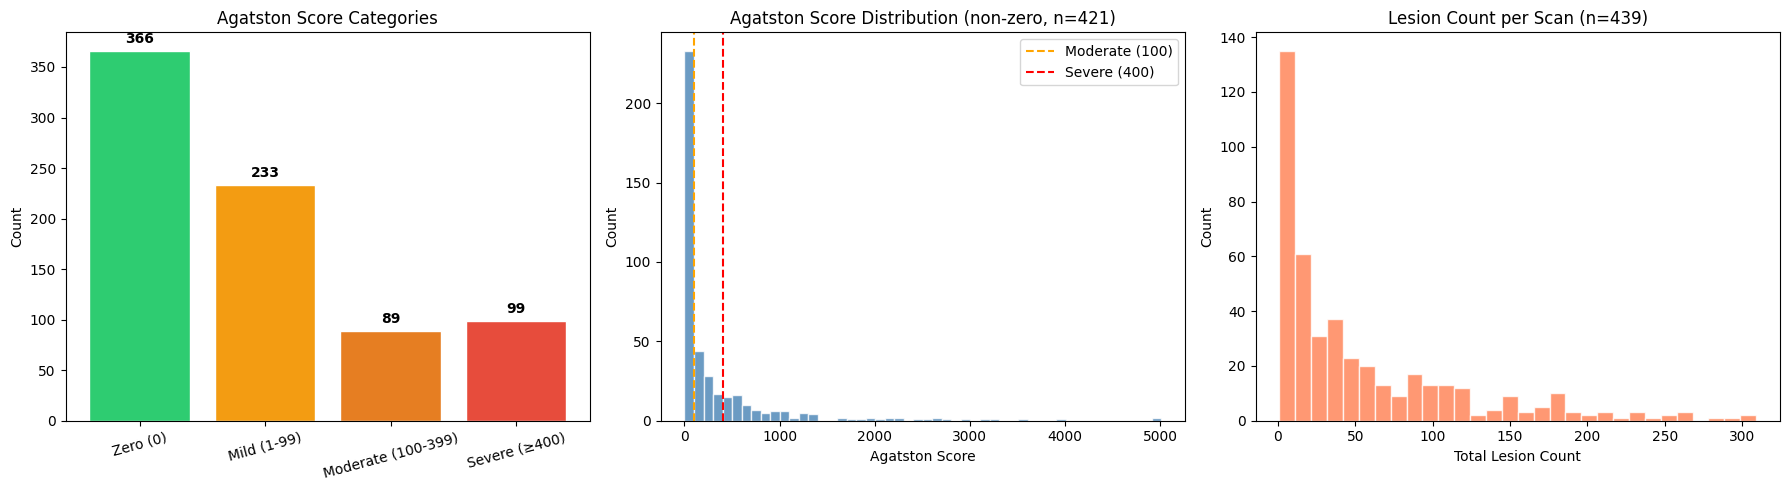

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

cat_counts = scan_registry['agatston_category'].value_counts().sort_index()
colors = ['#2ecc71', '#f39c12', '#e67e22', '#e74c3c']
bars = axes[0].bar([AGATSTON_CATEGORIES[i] for i in cat_counts.index],
                   cat_counts.values, color=colors, edgecolor='white')
for bar, count in zip(bars, cat_counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 5,
                 str(count), ha='center', va='bottom', fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].set_title('Agatston Score Categories')
axes[0].tick_params(axis='x', rotation=15)

nonzero_scores = scan_registry[scan_registry['agatston_score'] > 0]['agatston_score']
if len(nonzero_scores) > 0:
    axes[1].hist(nonzero_scores, bins=50, color='steelblue', edgecolor='white', alpha=0.8)
    axes[1].set_xlabel('Agatston Score')
    axes[1].set_ylabel('Count')
    axes[1].set_title(f'Agatston Score Distribution (non-zero, n={len(nonzero_scores)})')
    axes[1].axvline(x=100, color='orange', linestyle='--', label='Moderate (100)')
    axes[1].axvline(x=400, color='red', linestyle='--', label='Severe (400)')
    axes[1].legend()

lesion_counts = scan_registry[scan_registry['total_lesions'] > 0]['total_lesions']
if len(lesion_counts) > 0:
    axes[2].hist(lesion_counts, bins=30, color='coral', edgecolor='white', alpha=0.8)
    axes[2].set_xlabel('Total Lesion Count')
    axes[2].set_ylabel('Count')
    axes[2].set_title(f'Lesion Count per Scan (n={len(lesion_counts)})')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'agatston_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## Stratified Train/Val/Test Split
70/15/15, stratified by Agatston category so each split has proportional
representation across all burden levels.

In [13]:
def stratified_split(df, stratify_col='agatston_category',
                     train_ratio=0.70, val_ratio=0.15, test_ratio=0.15,
                     random_state=42):
    train_df, temp_df = train_test_split(
        df, test_size=(val_ratio + test_ratio),
        stratify=df[stratify_col], random_state=random_state
    )
    relative_test = test_ratio / (val_ratio + test_ratio)
    val_df, test_df = train_test_split(
        temp_df, test_size=relative_test,
        stratify=temp_df[stratify_col], random_state=random_state
    )
    return train_df, val_df, test_df

train_df, val_df, test_df = stratified_split(scan_registry)

for name, df in [('Train', train_df), ('Val', val_df), ('Test', test_df)]:
    print(f"\n{name}: {len(df)} scans")
    for label, count in df['agatston_label'].value_counts().sort_index().items():
        print(f"  {label}: {count} ({100*count/len(df):.1f}%)")

scan_registry['split'] = 'unassigned'
scan_registry.loc[train_df.index, 'split'] = 'train'
scan_registry.loc[val_df.index, 'split'] = 'val'
scan_registry.loc[test_df.index, 'split'] = 'test'


Train: 550 scans
  Mild (1-99): 163 (29.6%)
  Moderate (100-399): 62 (11.3%)
  Severe (≥400): 69 (12.5%)
  Zero (0): 256 (46.5%)

Val: 118 scans
  Mild (1-99): 35 (29.7%)
  Moderate (100-399): 13 (11.0%)
  Severe (≥400): 15 (12.7%)
  Zero (0): 55 (46.6%)

Test: 119 scans
  Mild (1-99): 35 (29.4%)
  Moderate (100-399): 14 (11.8%)
  Severe (≥400): 15 (12.6%)
  Zero (0): 55 (46.2%)


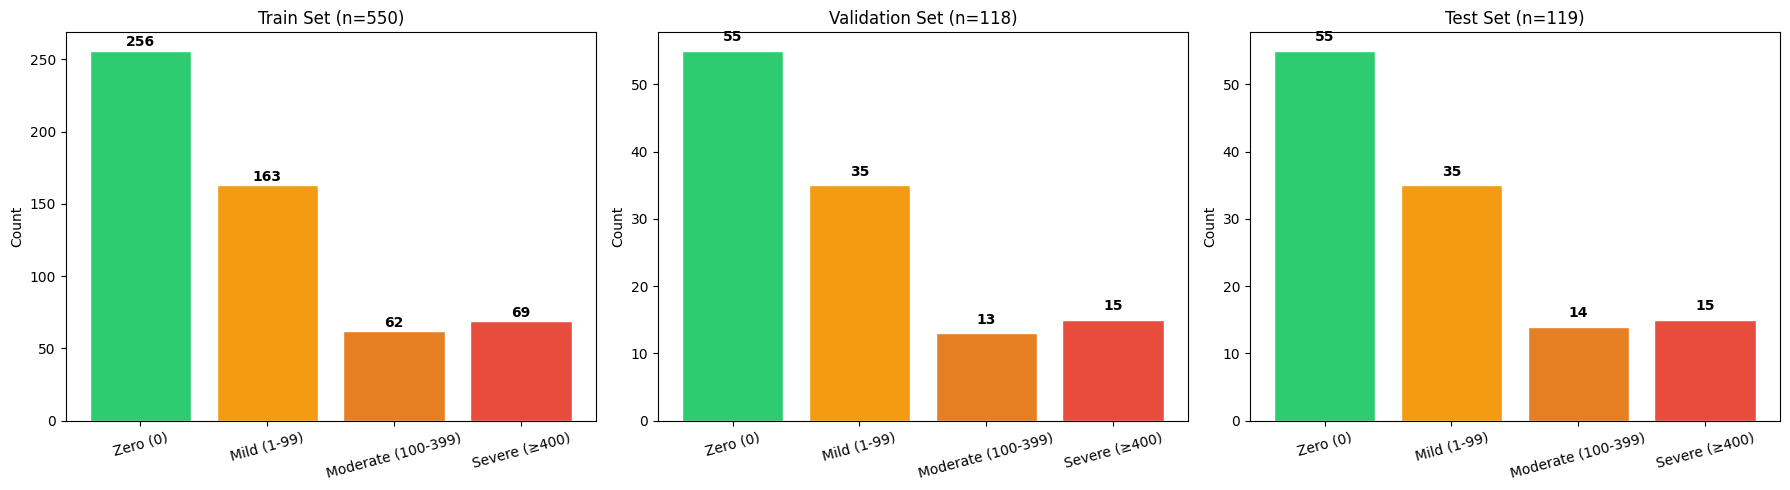

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors_map = {0: '#2ecc71', 1: '#f39c12', 2: '#e67e22', 3: '#e74c3c'}

for ax, (name, df) in zip(axes, [('Train', train_df), ('Validation', val_df), ('Test', test_df)]):
    cat_counts = df['agatston_category'].value_counts().sort_index()
    bars = ax.bar([AGATSTON_CATEGORIES[i] for i in cat_counts.index],
                  cat_counts.values,
                  color=[colors_map[i] for i in cat_counts.index],
                  edgecolor='white')
    for bar, count in zip(bars, cat_counts.values):
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
                str(count), ha='center', va='bottom', fontweight='bold')
    ax.set_title(f'{name} Set (n={len(df)})')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'stratified_split.png', dpi=150, bbox_inches='tight')
plt.show()

## Class Imbalance — Weighted Sampling
Zero-calcium dominates (~46%), so we use inverse-frequency weights for the
training sampler. Val/test stay unweighted to reflect real distribution.

In [15]:
def compute_sample_weights(df, category_col='agatston_category'):
    class_counts = df[category_col].value_counts().to_dict()
    n_samples = len(df)
    n_classes = len(class_counts)
    class_weights = {cls: n_samples / (n_classes * count)
                     for cls, count in class_counts.items()}
    sample_weights = df[category_col].map(class_weights).values
    return torch.DoubleTensor(sample_weights), class_weights

train_weights, class_weights = compute_sample_weights(train_df)
print("Class weights:")
for cat, weight in sorted(class_weights.items()):
    print(f"  {AGATSTON_CATEGORIES[cat]}: {weight:.3f}")

Class weights:
  Zero (0): 0.537
  Mild (1-99): 0.844
  Moderate (100-399): 2.218
  Severe (≥400): 1.993


## Augmentation
Keeping it conservative for radiomics — texture features (GLCM, GLRLM, etc.)
are sensitive to aggressive transforms. Only small flips, ±5° rotation, and
tiny noise. Augmentation is never applied during actual feature extraction.

In [16]:
class RadiomicsCompatibleAugmentation:
    def __init__(self, enable=True, flip_prob=0.5, rotation_range=5, noise_std=0.01):
        self.enable = enable
        self.flip_prob = flip_prob
        self.rotation_range = rotation_range
        self.noise_std = noise_std

    def __call__(self, image, mask):
        if not self.enable:
            return image, mask

        if np.random.random() < self.flip_prob:
            image = np.flip(image, axis=0).copy()
            mask = np.flip(mask, axis=0).copy()

        if self.rotation_range > 0:
            angle = np.random.uniform(-self.rotation_range, self.rotation_range)
            if abs(angle) > 0.5:
                from scipy.ndimage import rotate as scipy_rotate
                image = scipy_rotate(image, angle, axes=(0, 1), reshape=False, order=1, mode='nearest')
                mask = scipy_rotate(mask, angle, axes=(0, 1), reshape=False, order=0, mode='nearest')

        if self.noise_std > 0:
            noise = np.random.normal(0, self.noise_std, image.shape).astype(np.float32)
            image = image + noise

        return image, mask

## DataLoader
Loads raw HU + mask, applies windowing on the fly. Returns spacing and metadata
alongside tensors for downstream use. `return_raw_hu=True` keeps the unwindowed
volume available for Agatston/radiomics.

In [17]:
class COCARadiomicsDataset(Dataset):
    def __init__(self, scan_df, transform=None, hu_window='cardiac',
                 return_raw_hu=True, preload=False):
        self.scan_df = scan_df.reset_index(drop=True)
        self.transform = transform
        self.hu_window = hu_window
        self.return_raw_hu = return_raw_hu
        self.preload = preload
        self._cache = {}

        if preload:
            print(f"Preloading {len(self.scan_df)} volumes...")
            for idx in range(len(self.scan_df)):
                self._cache[idx] = self._load_volume(idx)

    def _load_volume(self, idx):
        row = self.scan_df.iloc[idx]
        img_nib = nib.load(row['img_path'])
        seg_nib = nib.load(row['seg_path'])
        return (img_nib.get_fdata().astype(np.float32),
                seg_nib.get_fdata().astype(np.float32),
                np.array(img_nib.header.get_zooms(), dtype=np.float32))

    def __len__(self):
        return len(self.scan_df)

    def __getitem__(self, idx):
        row = self.scan_df.iloc[idx]

        if self.preload and idx in self._cache:
            img_data, seg_data, spacing = [x.copy() for x in self._cache[idx]]
        else:
            img_data, seg_data, spacing = self._load_volume(idx)

        raw_hu = img_data.copy() if self.return_raw_hu else None

        if self.transform is not None:
            img_data, seg_data = self.transform(img_data, seg_data)

        if self.hu_window == 'cardiac':
            img_data = apply_cardiac_window(img_data)
        elif self.hu_window == 'calcium':
            img_data = apply_calcium_window(img_data)

        img_tensor = torch.from_numpy(img_data).unsqueeze(0)
        seg_tensor = torch.from_numpy(seg_data).unsqueeze(0)

        sample = {
            'image': img_tensor,
            'mask': seg_tensor,
            'spacing': torch.from_numpy(spacing),
            'scan_id': row['scan_id'],
            'patient_id': row['patient_id'],
            'agatston_score': row.get('agatston_score', -1),
            'agatston_category': row.get('agatston_category', -1),
        }
        if self.return_raw_hu:
            sample['raw_hu'] = torch.from_numpy(raw_hu).unsqueeze(0)

        return sample

In [18]:
train_augmentation = RadiomicsCompatibleAugmentation(enable=True, flip_prob=0.5, rotation_range=5, noise_std=0.01)

train_dataset = COCARadiomicsDataset(train_df, transform=train_augmentation, hu_window='cardiac', return_raw_hu=True)
val_dataset = COCARadiomicsDataset(val_df, transform=None, hu_window='cardiac', return_raw_hu=True)
test_dataset = COCARadiomicsDataset(test_df, transform=None, hu_window='cardiac', return_raw_hu=True)
radiomics_dataset = COCARadiomicsDataset(scan_registry, transform=None, hu_window='none', return_raw_hu=False)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}, Radiomics: {len(radiomics_dataset)}")

Train: 550, Val: 118, Test: 119, Radiomics: 787


In [19]:
train_sampler = WeightedRandomSampler(weights=train_weights, num_samples=len(train_dataset), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=1, sampler=train_sampler, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)
radiomics_loader = DataLoader(radiomics_dataset, batch_size=1, shuffle=False, num_workers=0)

In [20]:
sample = next(iter(train_loader))
print("Batch keys:", list(sample.keys()))
for key, val in sample.items():
    if isinstance(val, torch.Tensor):
        print(f"  {key}: {val.shape} {val.dtype}")

Batch keys: ['image', 'mask', 'spacing', 'scan_id', 'patient_id', 'agatston_score', 'agatston_category', 'raw_hu']
  image: torch.Size([1, 1, 287, 287, 201]) torch.float32
  mask: torch.Size([1, 1, 287, 287, 201]) torch.float32
  spacing: torch.Size([1, 3]) torch.float32
  patient_id: torch.Size([1]) torch.int64
  agatston_score: torch.Size([1]) torch.float64
  agatston_category: torch.Size([1]) torch.int64
  raw_hu: torch.Size([1, 1, 287, 287, 201]) torch.float32


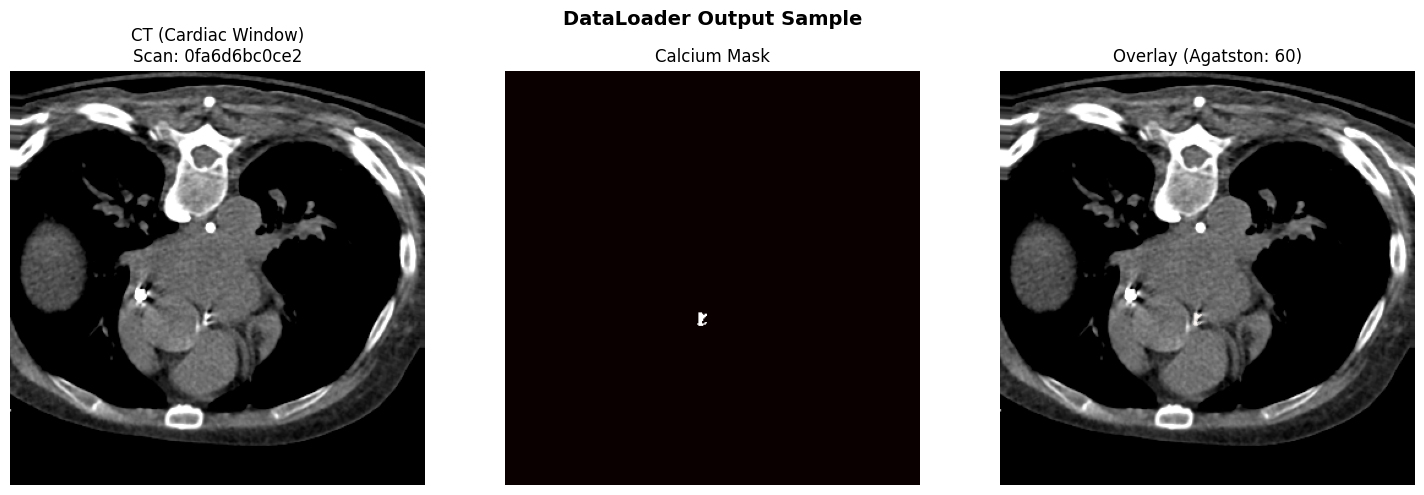

In [21]:
sample = next(iter(train_loader))
img = sample['image'][0, 0].numpy()
mask = sample['mask'][0, 0].numpy()
scan_id = sample['scan_id'][0]
ag_score = sample['agatston_score'][0].item()

calcium_slices = np.where(mask.sum(axis=(0, 1)) > 0)[0]
show_slice = calcium_slices[len(calcium_slices) // 2] if len(calcium_slices) > 0 else img.shape[2] // 2

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(img[:, :, show_slice].T, cmap='gray', origin='lower')
axes[0].set_title(f'CT (Cardiac Window)\nScan: {scan_id}')

axes[1].imshow(mask[:, :, show_slice].T, cmap='hot', origin='lower')
axes[1].set_title('Calcium Mask')

axes[2].imshow(img[:, :, show_slice].T, cmap='gray', origin='lower')
if mask[:, :, show_slice].sum() > 0:
    overlay = np.ma.masked_where(mask[:, :, show_slice].T == 0, mask[:, :, show_slice].T)
    axes[2].imshow(overlay, cmap='Reds', alpha=0.5, origin='lower')
axes[2].set_title(f'Overlay (Agatston: {ag_score:.0f})')

for ax in axes:
    ax.axis('off')
plt.suptitle('DataLoader Output Sample', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'dataloader_sample.png', dpi=150, bbox_inches='tight')
plt.show()

## Radiomics Compatibility Checks
Quick sanity checks — spacing should be consistent (isotropic 0.7mm), HU values
unclipped, masks binary.

In [22]:
n_check = min(20, len(scan_registry))
check_sample = scan_registry.sample(n_check, random_state=42)

spacings, hu_ranges, mask_stats = [], [], []
for _, row in check_sample.iterrows():
    img_nib = nib.load(row['img_path'])
    seg_nib = nib.load(row['seg_path'])
    spacings.append(img_nib.header.get_zooms())
    img_data = img_nib.get_fdata()
    seg_data = seg_nib.get_fdata()
    hu_ranges.append((img_data.min(), img_data.max()))
    unique_vals = np.unique(seg_data)
    mask_stats.append({
        'is_binary': set(unique_vals).issubset({0, 1}),
        'calcium_voxels': (seg_data > 0).sum(),
    })

spacings_arr = np.array(spacings)
hu_arr = np.array(hu_ranges)

print(f"Spacing X: {spacings_arr[:,0].min():.3f}–{spacings_arr[:,0].max():.3f} mm")
print(f"Spacing Y: {spacings_arr[:,1].min():.3f}–{spacings_arr[:,1].max():.3f} mm")
print(f"Spacing Z: {spacings_arr[:,2].min():.3f}–{spacings_arr[:,2].max():.3f} mm")
print(f"Isotropic: {np.allclose(spacings_arr, spacings_arr[0])}")
print(f"HU min range: [{hu_arr[:,0].min():.0f}, {hu_arr[:,0].max():.0f}]")
print(f"HU max range: [{hu_arr[:,1].min():.0f}, {hu_arr[:,1].max():.0f}]")
print(f"All masks binary: {all(ms['is_binary'] for ms in mask_stats)}")
print(f"Scans with calcium > 0: {(scan_registry['calcium_voxels'] > 0).sum()}")

Spacing X: 0.700–0.700 mm
Spacing Y: 0.700–0.700 mm
Spacing Z: 0.700–0.700 mm
Isotropic: True
HU min range: [-1024, -1021]
HU max range: [946, 3071]
All masks binary: True
Scans with calcium > 0: 447


## Save Final Registry

In [23]:
final_cols = ['patient_id', 'scan_id', 'calcium_voxels', 'num_slices_with_calcium',
              'img_path', 'seg_path', 'agatston_score', 'agatston_category',
              'agatston_label', 'total_lesions', 'split']
final_registry = scan_registry[[c for c in final_cols if c in scan_registry.columns]]
final_registry.to_csv(OUTPUT_DIR / 'coca_registry_final.csv', index=False)

print(f"Saved: {len(final_registry)} scans")
print(f"Train: {(final_registry['split']=='train').sum()}, "
      f"Val: {(final_registry['split']=='val').sum()}, "
      f"Test: {(final_registry['split']=='test').sum()}")

Saved: 787 scans
Train: 550, Val: 118, Test: 119


## Design Justification

The pipeline resamples to isotropic 0.7mm voxels (done upstream) which is important
for radiomics since texture features like GLCM and GLRLM produce inconsistent results
with anisotropic spacing. HU windowing is applied on-the-fly rather than baked into the
stored data — this preserves raw values needed for Agatston scoring (130 HU threshold)
and intensity-based radiomics features. The Agatston score itself uses the standard
density-weighted area method and serves as both a clinical reference point and the
stratification variable for the train/val/test split.

Augmentation is deliberately minimal: left-right flips, ±5° rotations, and σ=0.01
Gaussian noise. Anything more aggressive (elastic deformations, large rotations,
intensity shifts) would distort the texture statistics we're trying to extract.
Augmentation is only used during training and is never applied during radiomics
extraction. For class imbalance, inverse-frequency weighted sampling balances the
overrepresented zero-calcium group (~43%) without artificial data duplication. The
stratified split ensures all four Agatston categories appear proportionally in every
partition, which matters for validating that discovered phenotypes generalize.